In [1]:
import netCDF4 as nc
import numpy as np 
# import visulization packages 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
# import the daytime/solar angle/datetime calculation package 
import ephem
import datetime
import math

In [2]:
# define weather SPECs for drone (here we used the SPECs of DJI Phantom4 as an example)
W = 10
T2 = 40
T1 = 0 
P = 0.005

In [3]:
# read netCDF4 data 
data = nc.Dataset(r'sampledata_06_2019.nc','r')

In [4]:
# read dimension variables 
time = data.variables['time'][:]
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
# create a empty array to store binary filter results
dfly = np.empty((len(time),len(lat),len(lon)),dtype = np.float)
i = 0 
while i<len(time):
    # read weather variables 
    u = data.variables['u10'][i,:,:]
    v = data.variables['v10'][i,:,:]
    temp = data.variables['t2m'][i,:,:]
    pts = data.variables['tp'][i,:,:]
    # calculate wind speed 
    wind = (u ** 2 + v ** 2) ** 0.5
    # convert meter to milimeter
    pts = pts * 1000
    # convert kelvin to celsius
    temp = temp - 273.15
    # Array Filter
    # Wind
    wa = wind <= W
    wb = wind > W
    wind[wa] = 1
    wind[wb] = 0
    
    # Precipitation
    pa = pts <= P
    pb = pts > P
    pts[pa] = 1
    pts[pb] = 0

    # Temperature
    ta = (temp <= T2) & (temp >= T1)
    tb = (temp > T2) | (temp < T1)
    temp[ta] = 1
    temp[tb] = 0
    
    # check all                     
    Overall = wind + temp + pts  
    oa = Overall == 3
    ob = Overall != 3
    Overall[oa] = 1
    Overall[ob] = 0
    
    # store results 
    dfly[i, :, :] = Overall
    
    i += 1
    
data.close()

In [5]:
# calculate monthly flyability 
monthly_flyability = (np.sum(dfly,axis=0)/len(time))*100

In [6]:
# save the result as a netCDF4 file 
dronedata =nc.Dataset(r"test1.nc", 'w', format='NETCDF4_CLASSIC')
lat = dronedata.createDimension('lat', len(lat))
lon = dronedata.createDimension('lon', len(lon))
fly = dronedata.createVariable('flyability', np.float, ('lat', 'lon'))
fly[:] = monthly_flyability
dronedata.close()

In [7]:
# flip latitude and longitude for visulization
monthly_flyability = np.flip(monthly_flyability,0)

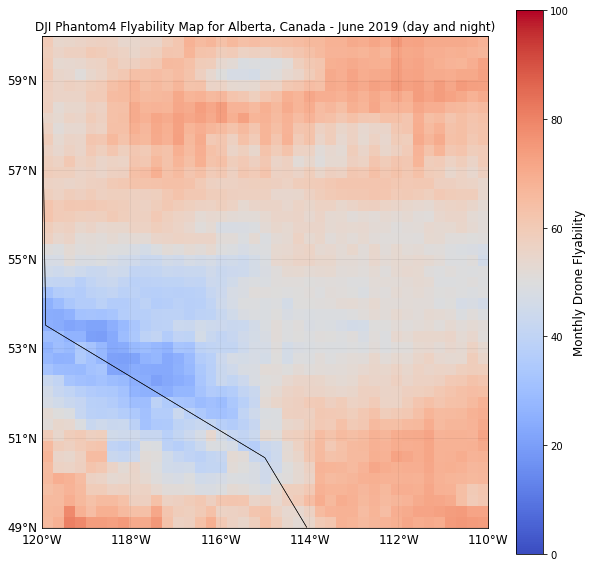

In [8]:
# visulzie the result
fig,axe = plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('White')
parallels = np.arange(49,62,2)
meridians = np.arange(-120,-108,2)
axe.set_title("DJI Phantom4 Flyability Map for Alberta, Canada - June 2019 (day and night)")
m = Basemap(ax=axe,
             llcrnrlon=-120,   # lower longitude
             llcrnrlat=49,  # lower latitude
             urcrnrlon=-110,   # uppper longitude
             urcrnrlat=60,   # uppper latitude
           )
m.drawstates()
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.1,fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.1,fontsize=12)
im = m.imshow(monthly_flyability,cmap='coolwarm',vmin=0,vmax=100)

cbar = fig.colorbar(im,orientation="vertical")
cbar.set_label('Monthly Drone Flyability (%)',fontsize=12)

#### Add daylight checking  

In [9]:
def calsunlight(lat, lon, year, time,d_tf):
    '''
    calsunlight can be used to determine wether the inputted location and time is daytime ot not 
    The inputs include latitude-longitud matrix, year, and the time series.  
    '''
    # create an empty array to store the daylight binary marker(0 = nighttime, 1 = daytime) 
    daylight = np.empty((len(time),len(lat),len(lon)),dtype = np.float)
    
    # for each time step we have a lat&long 2D matrix  
    for i in range(len(time)): 
        # calculate the timestep difference 
        dif = time[i]/24 - d_tf/24
        # calculate the day of the year 
        dy = int(dif) + 1
        # calculate the hour of the day
        hd = time[i]%24

        # calculate the date time object
        dtobj = datetime.datetime(year, 1, 1) + datetime.timedelta(dy - 1)
        # extract date object
        dobj = dtobj.date()
        # get the time object
        tobj = datetime.time(hd)
        # combine the datetime object
        nobj = datetime.datetime.combine(dobj, tobj)
        # For each cell of the matrix 
        for j in range(len(lat)):
            lati = str(lat[j])
            for k in range(len(lon)): 
                longi = str(lon[k])
                # create the location of the sun 
                sun = ephem.Sun()
                # create the observer object that relates to the current lat, long and time
                observer = ephem.Observer()
                observer.lat, observer.lon, observer.elevation = lati, longi, 0
                observer.date = nobj
                # calculate the solar angle 
                sun.compute(observer)
                current_sun_alt = sun.alt
                # convert the solar altitude to the degree
                ang = current_sun_alt*180/math.pi
                # we use the urban twilight as the boundary (-6 degree), if greater than -6 degree then it is a day time, 
                # otherwise it is a night time 
                if ang <= -6:
                    daylight[i,j,k]= 0 
                else: 
                    daylight[i,j,k]= 1
        
    print ("daylight array is ready!")
    return daylight        
        

In [10]:
# read ERA weather data
data = nc.Dataset(r'sampledata_06_2019.nc','r')
# extract time,latitude and longitude 
time = data.variables['time'][:]
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
# get the gregorian timestep for 1 am of January 1, 2019 
# June 1st is day 152 of the 2019
# we can use 1st time step of time list to minus 151*24 
t_fd = time[0] - 151*24 
# calculate daylight array 
Daylight = calsunlight(lat, lon, 2019, time,t_fd)

daylight array is ready!


In [11]:
# create a empty array to store binary filter results
dfly2 = np.empty((len(time),len(lat),len(lon)),dtype = np.float)
i = 0 
while i<len(time):
    # read weather variables 
    u = data.variables['u10'][i,:,:]
    v = data.variables['v10'][i,:,:]
    temp = data.variables['t2m'][i,:,:]
    pts = data.variables['tp'][i,:,:]
    day = Daylight[i,:,:]
    # calculate wind speed 
    wind = (u ** 2 + v ** 2) ** 0.5
    # convert meter to milimeter
    pts = pts * 1000
    # convert kelvin to celsius
    temp = temp - 273.15
    # Array Filter
    # Wind
    wa = wind <= W
    wb = wind > W
    wind[wa] = 1
    wind[wb] = 0
    
    # Precipitation
    pa = pts <= P
    pb = pts > P
    pts[pa] = 1
    pts[pb] = 0

    # Temperature
    ta = (temp <= T2) & (temp >= T1)
    tb = (temp > T2) | (temp < T1)
    temp[ta] = 1
    temp[tb] = 0
    
    # check all                     
    Overall = wind + temp + pts + day  
    oa = Overall == 4
    ob = Overall != 4
    Overall[oa] = 1
    Overall[ob] = 0
    
    # store results 
    dfly2[i, :, :] = Overall
    
    i += 1

In [12]:
# calculate monthly flyability 
monthly_flyability2 = (np.sum(dfly2,axis=0)/len(time))*100

In [13]:
# save the result as a netCDF4 file 
dronedata =nc.Dataset(r"test2.nc", 'w', format='NETCDF4_CLASSIC')
lat = dronedata.createDimension('lat', len(lat))
lon = dronedata.createDimension('lon', len(lon))
fly = dronedata.createVariable('flyability', np.float, ('lat', 'lon'))
fly[:] = monthly_flyability2
dronedata.close()

In [14]:
# flip latitude and longitude for visulization
monthly_flyability2 = np.flip(monthly_flyability2,0)

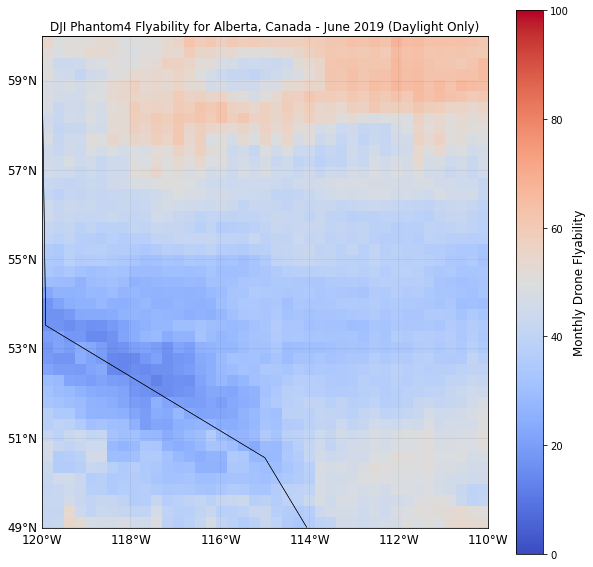

In [15]:
# visulzie the result
fig,axe = plt.subplots(1,1,figsize=(10,10))
fig.patch.set_facecolor('White')
parallels = np.arange(49,62,2)
meridians = np.arange(-120,-108,2)
axe.set_title("DJI Phantom4 Flyability for Alberta, Canada - June 2019 (Daylight Only)")
m = Basemap(ax=axe,
             llcrnrlon=-120,   # lower longitude
             llcrnrlat=49,  # lower latitude
             urcrnrlon=-110,   # uppper longitude
             urcrnrlat=60,   # uppper latitude
           )
m.drawstates()
m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.1,fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.1,fontsize=12)
im = m.imshow(monthly_flyability2,cmap='coolwarm',vmin=0,vmax=100)

cbar = fig.colorbar(im,orientation="vertical")
cbar.set_label('Monthly Drone Flyability (%)',fontsize=12)

#### Compare two maps

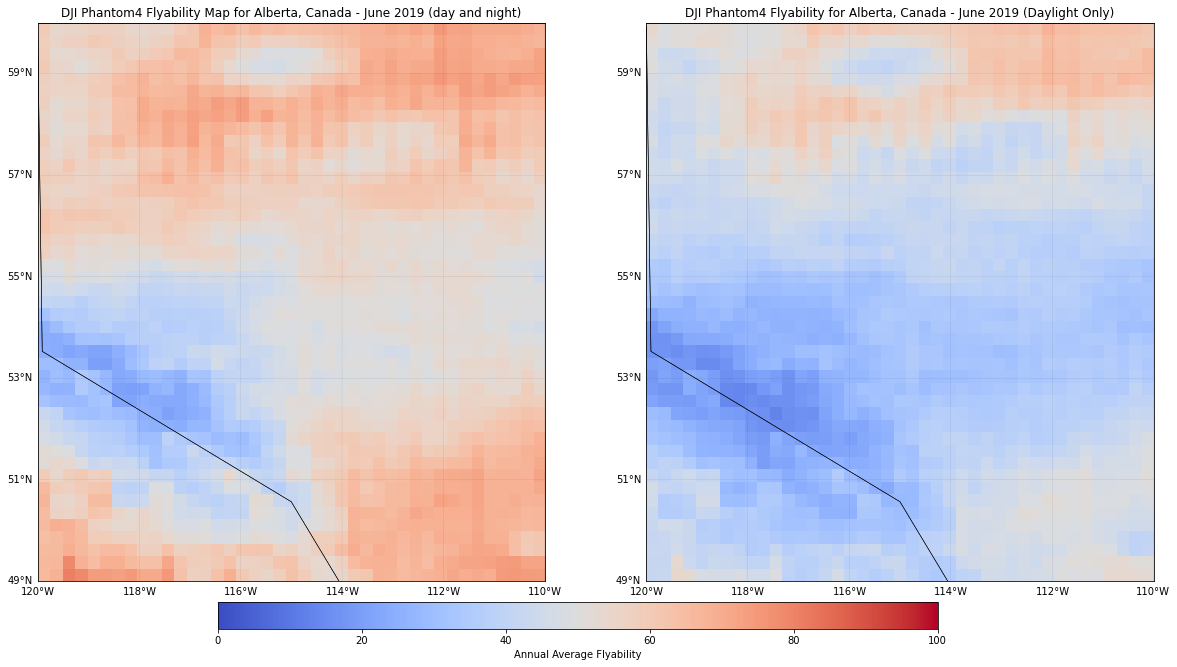

In [21]:
fig,axes = plt.subplots(1,2,figsize=(20,15))
fig.patch.set_facecolor('White')
title = ["DJI Phantom4 Flyability Map for Alberta, Canada - June 2019 (day and night)",
         "DJI Phantom4 Flyability for Alberta, Canada - June 2019 (Daylight Only)"]
Data = [monthly_flyability,monthly_flyability2]
parallels = np.arange(49,62,2)
meridians = np.arange(-120,-108,2)
i = 0 
for axe in axes.flat: 
    axe.set_title(title[i])
    m = Basemap(ax=axe,
             llcrnrlon=-120,   # lower longitude
             llcrnrlat=49,  # lower latitude
             urcrnrlon=-110,   # uppper longitude
             urcrnrlat=60,   # uppper latitude
           )
    m.drawstates()
    m.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.1)
    m.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0.1)
    im = m.imshow(Data[i],cmap='coolwarm',vmin=0,vmax=100)
    i = i + 1 
      
bar = np.array(Data)
cb_ax = fig.add_axes([0.25, 0.2,0.5, 0.025])
cbar = fig.colorbar(im,cax=cb_ax,orientation="horizontal")
cbar.set_label('Annual Average Flyability (%)')